In [1]:
from google.colab import drive
import pandas as pd
import os
from io import StringIO
# Monter Google Drive
drive.mount('/content/drive', force_remount= True) #force_remount = True permet d'avoir un fichier mis à jour si modifs sur google drive
df=pd.read_csv('/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/df_machine_learning.csv')
df['gravité_accident'] = df['gravité_accident'].replace({2: 'sans_urgence', 3: 'urgence', 4: 'sans_urgence'})
df['gravité_accident'].value_counts()

Mounted at /content/drive


,count
gravité_accident,
sans_urgence,190997
urgence,82229


Importation des bibliothèques nécessaires

In [2]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV


Régression logistique

Accuracy du modèle : 0.73
Précision : 0.71
Rappel : 0.73
F1-score : 0.70

Rapport de Classification :
              precision    recall  f1-score   support

sans_urgence       0.76      0.91      0.83     38246
     urgence       0.60      0.32      0.41     16400

    accuracy                           0.73     54646
   macro avg       0.68      0.61      0.62     54646
weighted avg       0.71      0.73      0.70     54646



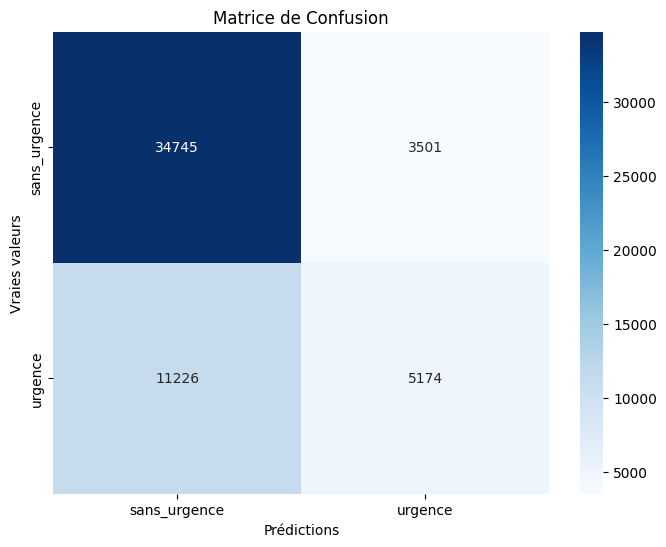

In [ ]:
# Préparation des données (Exemple de df à adapter)
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']


# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Définir la pipeline complète avec la régression logistique
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))])  # Régression Logistique avec itérations supplémentaires

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle : {accuracy:.2f}")



# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)


# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['sans_urgence','urgence'], yticklabels=['sans_urgence','urgence'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

Régression logistique avec oversampling

Accuracy du modèle avec oversampling : 0.68
Précision : 0.72
Rappel : 0.68
F1-score : 0.69

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.83      0.68      0.75     38246
           1       0.47      0.68      0.56     16400

    accuracy                           0.68     54646
   macro avg       0.65      0.68      0.65     54646
weighted avg       0.72      0.68      0.69     54646



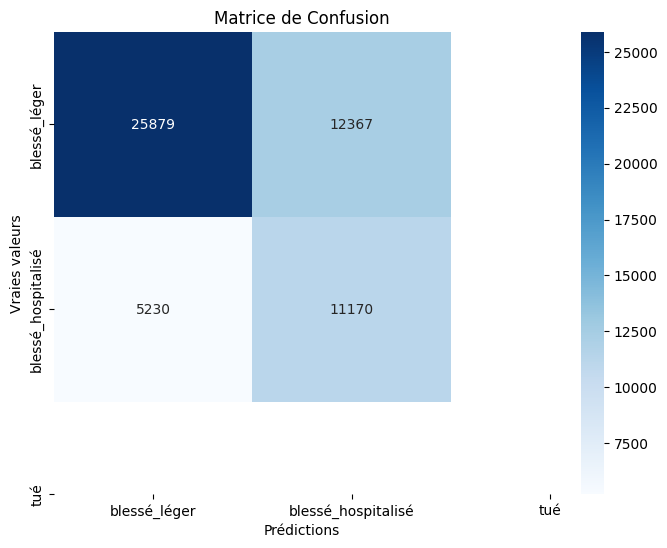

In [ ]:
# Préparation des données (Exemple de df à adapter)
X = df.drop(['Num_Acc','lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Préparation des données (Exemple de df à adapter)
X = df.drop(['Num_Acc','lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Définir la pipeline complète avec RandomUnderSampler (undersampling) et la régression logistique
pipeline = imPipeline([
    ('preprocessor', preprocessor),  # Prétraitement des données
    ('undersample', RandomUnderSampler(random_state=42)),  # Undersampling avec RandomUnderSampler
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Régression logistique
])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle avec undersampling : {accuracy:.2f}")

# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)

# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['blessé_léger','blessé_hospitalisé', 'tué'], yticklabels=['blessé_léger','blessé_hospitalisé', 'tué'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()


# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Définir la pipeline complète avec SMOTE (oversampling) et la régression logistique
pipeline = imPipeline([
    ('preprocessor', preprocessor),  # Prétraitement des données
    ('smote', SMOTE(random_state=42)),  # Oversampling avec SMOTE
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Régression logistique
])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle avec oversampling : {accuracy:.2f}")

# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)


# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['blessé_léger','blessé_hospitalisé', 'tué'], yticklabels=['blessé_léger','blessé_hospitalisé', 'tué'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

REGRESSION LOGISTIQUE AVEC UNDERSAMPLING

Accuracy du modèle avec undersampling : 0.68
Précision : 0.72
Rappel : 0.68
F1-score : 0.69

Rapport de Classification :
              precision    recall  f1-score   support

sans_urgence       0.83      0.68      0.75     38246
     urgence       0.48      0.67      0.56     16400

    accuracy                           0.68     54646
   macro avg       0.65      0.68      0.65     54646
weighted avg       0.72      0.68      0.69     54646



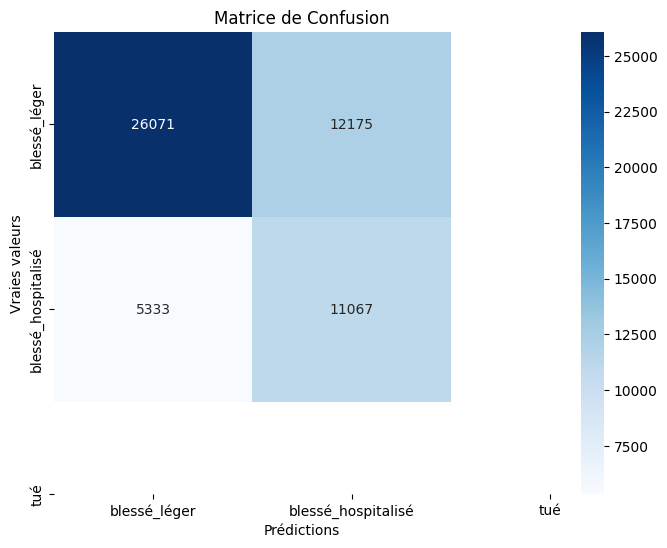

Accuracy du modèle avec undersampling : 0.68
Précision : 0.72
Rappel : 0.68
F1-score : 0.69

Rapport de Classification :
              precision    recall  f1-score   support

sans_urgence       0.83      0.68      0.75     38246
     urgence       0.48      0.67      0.56     16400

    accuracy                           0.68     54646
   macro avg       0.65      0.68      0.65     54646
weighted avg       0.72      0.68      0.69     54646



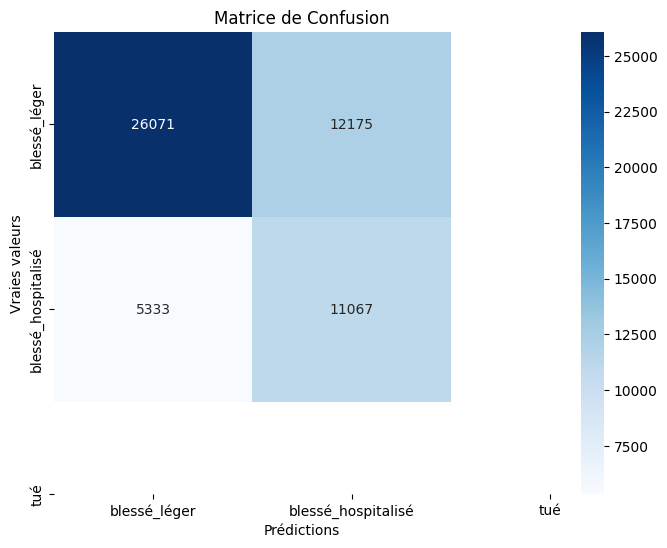

In [ ]:
# Préparation des données (Exemple de df à adapter)
X = df.drop(['Num_Acc','lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Préparation des données (Exemple de df à adapter)
X = df.drop(['Num_Acc','lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Définir la pipeline complète avec RandomUnderSampler (undersampling) et la régression logistique
pipeline = imPipeline([
    ('preprocessor', preprocessor),  # Prétraitement des données
    ('undersample', RandomUnderSampler(random_state=42)),  # Undersampling avec RandomUnderSampler
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Régression logistique
])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle avec undersampling : {accuracy:.2f}")

# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)

# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['blessé_léger','blessé_hospitalisé', 'tué'], yticklabels=['blessé_léger','blessé_hospitalisé', 'tué'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Définir la pipeline complète avec RandomUnderSampler (undersampling) et la régression logistique
pipeline = imPipeline([
    ('preprocessor', preprocessor),  # Prétraitement des données
    ('undersample', RandomUnderSampler(random_state=42)),  # Undersampling avec RandomUnderSampler
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Régression logistique
])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle avec undersampling : {accuracy:.2f}")

# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)

# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['blessé_léger','blessé_hospitalisé', 'tué'], yticklabels=['blessé_léger','blessé_hospitalisé', 'tué'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

Régression logistique avec métrique pondérée pour optimiser le F1_score

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué',
             'blessé_léger', 'indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

from sklearn.preprocessing import LabelEncoder

# Encoder les labels en entiers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['gravité_accident'])  # Convertit 'sans_urgence' -> 0 et 'urgence' -> 1

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos

# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage OneHot
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma', 'nationale_departementale_communale', 'autoroute', 'autre_route',
                        'sens_unique', 'bidirectionnel', 'route_seche', 'route_mouillee_enneigee',
                        'etat_route_autre', 'usager_count', 'total_sans_secu', 'total_ceinture',
                        'total_casque', 'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
                        'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV', 'pax_AR',
                        'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17', '18-60', '61-95',
                        'obstacle_fixe', 'obstacle_mobile', 'aucun_choc', 'choc_AV', 'choc_AR', 'choc_cote',
                        'choc_tonneaux', 'VL_VU', '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)],
    remainder='passthrough')  # Laisser les autres variables inchangées

# Définir les différentes pondérations à tester
# Définir les différentes pondérations à tester (déjà définies dans ton code précédent)
class_weights_list = [
    {0: 1, 1: 2},
    {0: 1, 1: 3},
    {0: 1, 1: 5},
    {0: 1, 1: 10},
]

# Classe 0: Sans_urgence
# Classe 1: urgence

# Définir une fonction pour le F1-score pondéré
def weighted_f1_score(y_true, y_pred, class_weights):
    f1_per_class = f1_score(y_true, y_pred, average=None)
    weights = [class_weights.get(i, 1) for i in np.unique(y_true)]
    weighted_f1 = np.dot(f1_per_class, weights) / sum(weights)
    return weighted_f1

# Tester plusieurs configurations de `class_weight`
results = {}

for class_weights in class_weights_list:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Transformation des variables
        ('classifier', LogisticRegression(
            max_iter=10000, solver = "saga",
            random_state=42))  # Régression logistique
    ])

    f1_scores = cross_val_score(
        pipeline, X_train, y_train, cv=5,
        scoring=lambda est, X, y: weighted_f1_score(y, est.predict(X), class_weights)
    )

    results[str(class_weights)] = np.mean(f1_scores)

# Afficher les résultats pour chaque configuration de pondération
for class_weights, score in results.items():
    print(f"Configuration des poids {class_weights} -> F1-score pondéré : {score}")

# Trouver la meilleure configuration de poids
best_class_weights = max(results, key=results.get)
print(f"\nMeilleure configuration de pondération : {best_class_weights}")

# Entraîner le modèle avec les poids optimaux
pipeline_with_optimal_weights = Pipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('classifier', LogisticRegression(
        class_weight=eval(best_class_weights),  # Appliquer les poids optimaux
        max_iter=1000,
        random_state=42))
])

pipeline_with_optimal_weights.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = pipeline_with_optimal_weights.predict(X_test)

# Calcul du F1-score pondéré
f1_optimal = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score pondéré avec les poids optimaux : {f1_optimal}")

Régression logistique avec métrique pondérée pour optimiser le RECALL

In [ ]:
from sklearn.metrics import recall_score


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué',
             'blessé_léger', 'indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

from sklearn.preprocessing import LabelEncoder

# Encoder les labels en entiers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['gravité_accident'])  # Convertit 'sans_urgence' -> 0 et 'urgence' -> 1

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos

# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage OneHot
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma', 'nationale_departementale_communale', 'autoroute', 'autre_route',
                        'sens_unique', 'bidirectionnel', 'route_seche', 'route_mouillee_enneigee',
                        'etat_route_autre', 'usager_count', 'total_sans_secu', 'total_ceinture',
                        'total_casque', 'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
                        'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV', 'pax_AR',
                        'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17', '18-60', '61-95',
                        'obstacle_fixe', 'obstacle_mobile', 'aucun_choc', 'choc_AV', 'choc_AR', 'choc_cote',
                        'choc_tonneaux', 'VL_VU', '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)],
    remainder='passthrough')  # Laisser les autres variables inchangées

# Définir les différentes pondérations à tester
# Définir les différentes pondérations à tester (déjà définies dans ton code précédent)
class_weights_list = [
    {0: 1, 1: 2},
    {0: 1, 1: 3},
    {0: 1, 1: 5},
    {0: 1, 1: 10},
]

# Classe 0: Sans_urgence
# Classe 1: urgence

# Définir une fonction pour le rappel pondéré
def weighted_recall(y_true, y_pred, class_weights):
    # Calculer le rappel pour chaque classe
    recall_per_class = recall_score(y_true, y_pred, average=None)

    # Associer les poids aux classes dans le même ordre que dans recall_per_class
    weights = [class_weights.get(i, 1) for i in range(len(recall_per_class))]

    # Calculer le rappel pondéré en fonction des poids
    weighted_recall_score = np.dot(recall_per_class, weights) / sum(weights)
    return weighted_recall_score


# Initialiser un dictionnaire pour stocker les résultats du rappel pondéré
results_recall = {}

# Pour chaque configuration de poids, effectuer une validation croisée et calculer le rappel pondéré
for class_weights in class_weights_list:
    # Utiliser cross_val_score pour évaluer la performance avec les poids de classes
    recall_scores = cross_val_score(
        pipeline, X_train, y_train, cv=5,
        scoring=lambda est, X, y: weighted_recall(y, est.predict(X), class_weights)
    )

    # Enregistrer la moyenne des scores de rappel pondéré
    results_recall[str(class_weights)] = np.mean(recall_scores)

# Afficher les résultats pour chaque configuration de pondération
for class_weights, score in results_recall.items():
    print(f"Configuration des poids {class_weights} -> Rappel pondéré : {score}")

# Trouver la configuration qui donne le meilleur rappel pondéré
best_class_weights_recall = max(results_recall, key=results_recall.get)
print(f"\nMeilleure configuration de pondération (Rappel) : {best_class_weights_recall}")

# Créer la pipeline en utilisant les poids optimaux dans le classificateur RandomForest
for class_weights in class_weights_list:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Transformation des variables
        ('classifier', LogisticRegression(
            max_iter=10000, solver = "saga",
            random_state=42))  # Régression logistique
    ])

# Entraîner le modèle avec les poids optimaux
pipeline_with_optimal_weights.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = pipeline_with_optimal_weights.predict(X_test)

# Evaluation de la performance du modèle

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall_optimal = recall_score(y_test, y_pred, average='weighted')
f1_score = f1_score(y_test, y_pred, average='weighted')

print("\n📊 **Performance du modèle optimal**")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall_optimal: {recall:.2f}")
print(f"F1-score: {f1_score: .2f}")
print("\nRapport de Classification:")
print(classification_report(y_test, y_pred))

# 📌 **Matrice de confusion**
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()

Grid search avec scoring personnalisé pour meilleur F1_score pour la classe 1 ( hospitalisé)


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué',
             'blessé_léger', 'indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']



# Encoder les labels en entiers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['gravité_accident'])  # Convertit 'sans_urgence' -> 0 et 'urgence' -> 1


# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos

# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage OneHot
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma', 'nationale_departementale_communale', 'autoroute', 'autre_route',
                        'sens_unique', 'bidirectionnel', 'route_seche', 'route_mouillee_enneigee',
                        'etat_route_autre', 'usager_count', 'total_sans_secu', 'total_ceinture',
                        'total_casque', 'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
                        'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV', 'pax_AR',
                        'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17', '18-60', '61-95',
                        'obstacle_fixe', 'obstacle_mobile', 'aucun_choc', 'choc_AV', 'choc_AR', 'choc_cote',
                        'choc_tonneaux', 'VL_VU', '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)],
    remainder='passthrough')  # Laisser les autres variables inchangées

# Définir un scoring personnalisé pour optimiser le F1-score de la classe 1
def f1_score_class_1(y_true, y_pred):
    return f1_score(y_true, y_pred, labels=[1], average='binary')  # F1 pour la classe 1

# Créer un scorer avec le F1 personnalisé
f1_class_1_scorer = make_scorer(f1_score_class_1)

# Pipeline avec régression logistique et scoring personnalisé
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('classifier', LogisticRegression(
        max_iter=10000, solver="saga", random_state=42))  # Régression logistique
])

# Cross-validation avec le scoring personnalisé
f1_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=f1_class_1_scorer)

# Afficher la moyenne du F1-score pour la classe 1
print(f"F1-score moyen pour la classe 1 : {np.mean(f1_scores):.4f}")

# Entraîner le modèle final avec ce scoring personnalisé
pipeline.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Calcul du F1-score pour la classe 1 sur l'ensemble de test
f1_optimal = f1_score_class_1(y_test, y_pred)
print(f"F1-score de la classe 1 sur l'ensemble de test : {f1_optimal:.4f}")

Grid search avec scoring personnalisé pour meilleur recall pour la classe 1 ( urgent)


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, make_scorer
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué',
             'blessé_léger', 'indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']



# Encoder les labels en entiers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['gravité_accident'])  # Convertit 'sans_urgence' -> 0 et 'urgence' -> 1

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos

# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage OneHot
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma', 'nationale_departementale_communale', 'autoroute', 'autre_route',
                        'sens_unique', 'bidirectionnel', 'route_seche', 'route_mouillee_enneigee',
                        'etat_route_autre', 'usager_count', 'total_sans_secu', 'total_ceinture',
                        'total_casque', 'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
                        'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV', 'pax_AR',
                        'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17', '18-60', '61-95',
                        'obstacle_fixe', 'obstacle_mobile', 'aucun_choc', 'choc_AV', 'choc_AR', 'choc_cote',
                        'choc_tonneaux', 'VL_VU', '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)],
    remainder='passthrough')  # Laisser les autres variables inchangées

# Définir un scoring personnalisé pour optimiser le recall de la classe 1
def recall_score_class_1(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=[1], average='binary')  # Recall pour la classe 1

# Créer un scorer avec le recall personnalisé
recall_class_1_scorer = make_scorer(recall_score_class_1)

# Pipeline avec régression logistique et scoring personnalisé
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('classifier', LogisticRegression(
        max_iter=10000, solver="saga", random_state=42))  # Régression logistique
])

# Cross-validation avec le scoring personnalisé pour le recall de la classe 1
recall_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=recall_class_1_scorer)

# Afficher la moyenne du recall pour la classe 1
print(f"Recall moyen pour la classe 1 : {np.mean(recall_scores):.4f}")

# Entraîner le modèle final avec ce scoring personnalisé
pipeline.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Calcul du recall pour la classe 1 sur l'ensemble de test
recall_optimal = recall_score_class_1(y_test, y_pred)
print(f"Recall de la classe 1 sur l'ensemble de test : {recall_optimal:.4f}")